## 1. Setup & Installation

In [21]:
!pip -q install -U transformers accelerate bitsandbytes datasets evaluate rouge_score scikit-learn

import os, random, json, re
import numpy as np
import torch

print("PyTorch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    import torch.backends.cudnn as cudnn
    cudnn.deterministic = True
    cudnn.benchmark = False

!nvidia-smi -L || echo "No GPU detected (CPU runtime)"


PyTorch: 2.6.0+cu124
CUDA available: True
GPU 0: Tesla T4 (UUID: GPU-1c079070-eebb-c201-2cf7-c1d5a9c13564)


##2. Data Access & Path (Mount Drive)

In [22]:
from google.colab import drive
drive.mount('/content/drive')

DATA_PATH = '/content/drive/MyDrive/capstone_data/reviews_ready.csv'   # ganti sesuai file
OUT_PATH  = '/content/drive/MyDrive/capstone_data/reviews_with_preds.csv'
TEXT_COL_FALLBACK = None  # kalau kolom text bukan "review_text"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##3. Load Data + Weak Label + Sampling

In [23]:
import pandas as pd
import numpy as np

df = pd.read_csv(DATA_PATH)
text_col = 'review_text' if 'review_text' in df.columns else (TEXT_COL_FALLBACK or df.columns[0])
df = df.dropna(subset=[text_col]).copy()
df[text_col] = df[text_col].astype(str).str.strip()

def weak_label(score):
    try: s = float(score)
    except: return np.nan
    if s >= 7: return "Positive"
    if s >= 4: return "Neutral"
    return "Negative"

if 'score_user' in df.columns:
    df['weak_sentiment'] = df['score_user'].apply(weak_label)
else:
    df['weak_sentiment'] = np.nan

print("Data shape:", df.shape)
display(df.head(3))
print(df['weak_sentiment'].value_counts(dropna=False))

N = 200
min_chars = 40

df_f = df[df[text_col].str.len() >= min_chars]
sample = df_f.sample(min(N, len(df_f)), random_state=42).reset_index(drop=True)

print("\nSample shape:", sample.shape)
display(sample.head())

Data shape: (184958, 11)


,uid,anime_uid,title,genre,members,popularity,ranked,score_user,review_text,review_len,weak_sentiment
0,293931,20707,"""0""",['Music'],2594,7345,11123.0,6.0,"Before this, I had zero exposure to the name “...",767,Neutral
1,233848,20707,"""0""",['Music'],2594,7345,11123.0,6.0,"This is an AMV, a song made by CHiAKi KURiYAMA...",717,Neutral
2,199765,20707,"""0""",['Music'],2594,7345,11123.0,6.0,"Well, I finally can watch this, so I'm reviewi...",772,Neutral


weak_sentiment
Positive    135079
Neutral      35271
Negative     14608
Name: count, dtype: int64

Sample shape: (200, 11)


,uid,anime_uid,title,genre,members,popularity,ranked,score_user,review_text,review_len,weak_sentiment
0,143001,14349,Little Witch Academia,"['Adventure', 'Comedy', 'Magic', 'Fantasy', 'S...",224526,470,696.0,8.0,"""Trigger saved anime."" This is a phrase the an...",3359,Positive
1,104313,16187,"Marriage Blue: ""Konyakusha ga Iru no ni, Doush...",['Hentai'],3097,6950,NaN,3.0,Well this is a good anime to get introduced to...,1454,Negative
2,168155,18277,Strike the Blood,"['Action', 'Harem', 'Supernatural', 'Ecchi', '...",405376,204,2685.0,7.0,I found the strong point in this series being ...,1326,Positive
3,34931,8937,Toaru Majutsu no Index II,"['Action', 'Magic', 'Sci-Fi', 'Super Power']",298305,326,1143.0,9.0,"(This is my first review,so please forgive me ...",2354,Positive
4,30177,7655,Major S6,"['Comedy', 'Drama', 'Shounen', 'Sports']",41466,2136,175.0,9.0,“The final course” The Story… Continuing the m...,6103,Positive


##4. Load Granite 4-bit (Model & Tokenizer)

In [24]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig

MODEL_ID = "ibm-granite/granite-3.3-8b-instruct"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16 if torch.cuda.is_available() else torch.float16,
)

tokenizer = AutoTokenizer.from_pretrained(MODEL_ID, use_fast=True, trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(
    MODEL_ID,
    device_map="auto",
    quantization_config=bnb_config,
    trust_remote_code=True,
)

model.eval()


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

GraniteForCausalLM(
  (model): GraniteModel(
    (embed_tokens): Embedding(49159, 4096, padding_idx=0)
    (layers): ModuleList(
      (0-39): 40 x GraniteDecoderLayer(
        (self_attn): GraniteAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
        )
        (mlp): GraniteMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=12800, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=12800, bias=False)
          (down_proj): Linear4bit(in_features=12800, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): GraniteRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): GraniteRMSNorm((4096,), eps=1e-05)
      )
    )
 

##5. Prompt Template + Few-shots + Parser

In [25]:
ALLOWED = {"Positive","Neutral","Negative"}

SYSTEM_PROMPT = (
    "You are an anime review classifier and summarizer.\n"
    'Return ONLY valid JSON with EXACT keys and no extra text:\n'
    '{"sentiment":"Positive|Neutral|Negative","summary":"<≤25 words>"}\n'
    "Decision rules:\n"
    "- Positive: pujian/emosi positif dominan.\n"
    "- Negative: kritik/emosi negatif dominan.\n"
    "- Neutral: campur seimbang / deskriptif / ambigu.\n"
    "Language: follow input. No explanations."
)

FEW_SHOTS = [
     {"role":"user","content":"Animasi bagus tapi cerita datar dan lambat."},
    {"role":"assistant","content":'{"sentiment":"Neutral","summary":"Visual oke namun cerita datar dan pacing lambat."}'},
    {"role":"user","content":"Story menyentuh, musik bikin merinding!"},
    {"role":"assistant","content":'{"sentiment":"Positive","summary":"Kisah menyentuh diperkuat musik yang emosional."}'},
    {"role":"user","content":"Ada adegan seru, tapi pacing berantakan dan karakternya dangkal."},
    {"role":"assistant","content":'{"sentiment":"Negative","summary":"Aksi seru terhalang pacing buruk dan karakter dangkal."}'},
]

def build_messages(text: str):
    return [{"role":"system","content":SYSTEM_PROMPT}, *FEW_SHOTS, {"role":"user","content":text}]

import re, json
_JSON_BLOCK = re.compile(r"\{.*?\}", re.DOTALL)

def safe_parse_json(s: str):
    try:
        obj = json.loads(s)
        return obj.get("sentiment","Neutral"), obj.get("summary","")
    except:
        m = _JSON_BLOCK.search(s)
        if m:
            try:
                obj = json.loads(m.group(0))
                return obj.get("sentiment","Neutral"), obj.get("summary","")
            except: pass
    return "Neutral", s[:150]


##6. Batched Inference (predict_batch)

In [29]:
from tqdm.auto import tqdm
import torch

@torch.no_grad()
def predict_batch(texts, max_input_len=768, max_new_tokens=96):
    """
    Batched inference hemat T4.
    - Potong input per item ke ~1200 char (hemat token).
    - max_input_len 768 & max_new_tokens 96 biar cepat.
    """
    # Siapkan prompt per item
    prompts = []
    for t in texts:
        messages = build_messages(str(t)[:1200])  # dari 2000 -> 1200 biar cepat
        prompt = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
        prompts.append(prompt)

    # Batch encode
    enc = tokenizer(
        prompts,
        padding=True,
        truncation=True,
        max_length=max_input_len,
        return_tensors="pt"
    )
    enc = {k: v.to(model.device) for k, v in enc.items()}

    # Pastikan ada EOS token id
    eos_id = tokenizer.eos_token_id
    if eos_id is None:
        # fallback: pakai pad_token_id kalau eos gak ada
        eos_id = tokenizer.pad_token_id

    # Generate
    gen = model.generate(
        **enc,
        max_new_tokens=max_new_tokens,
        do_sample=False,
        num_beams=1,
        pad_token_id=tokenizer.eos_token_id or tokenizer.pad_token_id,
        eos_token_id=eos_id,
    )

    # Ambil hanya bagian yang di-generate
    gen_only = gen[:, enc["input_ids"].shape[1]:]
    outputs = tokenizer.batch_decode(gen_only, skip_special_tokens=True)

    # Parse ke (sentiment, summary)
    pairs = [safe_parse_json(o) for o in outputs]
    return pairs, outputs

# --- Smoke test: PAKAI SAMPLE, BUKAN DF ---
src = sample if 'sample' in globals() else df  # jaga-jaga kalau kamu lupa bikin sample
pairs, raw = predict_batch([src[text_col].iloc[0]])
print("RAW:", raw[0])
print("PARSED:", pairs[0])


RAW: {"sentiment":"Positive","summary":"Little Witch Academia praised for coherent plot, engaging characters, and nostalgic appeal."}
PARSED: ('Positive', 'Little Witch Academia praised for coherent plot, engaging characters, and nostalgic appeal.')


##7. Final Inference Loop + Checkpoint + Metrics

In [30]:
from sklearn.metrics import classification_report, f1_score, accuracy_score
from datetime import datetime
import pandas as pd, os, gc
import torch

# Pakai sample kalau tersedia, fallback ke df
src = sample if 'sample' in globals() else df

BATCH_SIZE = 4                 # stabil di T4; kalau kuat bisa 6-8
CHECKPOINT_EVERY = 100         # simpan progress tiap 100 contoh
sentiments, summaries, raws = [], [], []
total = len(src)

for i in tqdm(range(0, total, BATCH_SIZE)):
    chunk = src[text_col].iloc[i:i+BATCH_SIZE].tolist()

    # Coba batch; kalau OOM, fallback satu-satu
    try:
        pairs, outs = predict_batch(chunk)
    except RuntimeError as e:
        print(f"\n[WARN] Batch gagal (kemungkinan OOM) di index {i}. Fallback 1-by-1.")
        torch.cuda.empty_cache()
        pairs, outs = [], []
        for t in chunk:
            p, o = predict_batch([t])
            pairs.extend(p); outs.extend(o)

    sents, sums = zip(*pairs)
    sentiments.extend(sents)
    summaries.extend(sums)
    raws.extend(outs)

    # Checkpoint berkala (overwrite file yang sama biar rapi)
    if ((i + BATCH_SIZE) % CHECKPOINT_EVERY == 0) or (i + BATCH_SIZE >= total):
        df_ckpt = src.iloc[:len(sentiments)].copy()
        df_ckpt["pred_sentiment"] = sentiments
        df_ckpt["pred_summary"] = summaries
        df_ckpt["raw_output"] = raws
        ckpt_file = OUT_PATH.replace(".csv", "_ckpt.csv")
        df_ckpt.to_csv(ckpt_file, index=False)
        print(f"[Checkpoint] saved {len(df_ckpt)}/{total} -> {ckpt_file}")

        # Bersihin memori dikit
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

# Hasil final
df_out = src.copy()
df_out["pred_sentiment"] = sentiments
df_out["pred_summary"]  = summaries
df_out["raw_output"]    = raws

print("Preview:")
display(df_out.head())

# Metrics kalau ada weak label
if "weak_sentiment" in df_out.columns and df_out["weak_sentiment"].notna().any():
    mask = df_out["weak_sentiment"].notna()
    print(classification_report(
        df_out.loc[mask, "weak_sentiment"],
        df_out.loc[mask, "pred_sentiment"],
        labels=["Negative", "Neutral", "Positive"]
    ))

# Save final dengan timestamp
timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
out_file = OUT_PATH.replace(".csv", f"_{timestamp}.csv")
df_out.to_csv(out_file, index=False)
print("Final saved:", out_file)


  0%|          | 0/50 [00:00<?, ?it/s]

[Checkpoint] saved 100/200 -> /content/drive/MyDrive/capstone_data/reviews_with_preds_ckpt.csv
[Checkpoint] saved 200/200 -> /content/drive/MyDrive/capstone_data/reviews_with_preds_ckpt.csv
Preview:


,uid,anime_uid,title,genre,members,popularity,ranked,score_user,review_text,review_len,weak_sentiment,pred_sentiment,pred_summary,raw_output
0,143001,14349,Little Witch Academia,"['Adventure', 'Comedy', 'Magic', 'Fantasy', 'S...",224526,470,696.0,8.0,"""Trigger saved anime."" This is a phrase the an...",3359,Positive,Positive,Little Witch Academia praised for coherent plo...,"{""sentiment"":""Positive"",""summary"":""Little Witc..."
1,104313,16187,"Marriage Blue: ""Konyakusha ga Iru no ni, Doush...",['Hentai'],3097,6950,NaN,3.0,Well this is a good anime to get introduced to...,1454,Negative,Neutral,"Intro anime hentai, normal dan sedikit berat. ...","{""sentiment"":""Neutral"",""summary"":""Intro anime ..."
2,168155,18277,Strike the Blood,"['Action', 'Harem', 'Supernatural', 'Ecchi', '...",405376,204,2685.0,7.0,I found the strong point in this series being ...,1326,Positive,Negative,"Story intriguing at start, but harem aspect sl...","{""sentiment"":""Negative"",""summary"":""Story intri..."
3,34931,8937,Toaru Majutsu no Index II,"['Action', 'Magic', 'Sci-Fi', 'Super Power']",298305,326,1143.0,9.0,"(This is my first review,so please forgive me ...",2354,Positive,Positive,Art and story significantly improved from firs...,"{""sentiment"":""Positive"",""summary"":""Art and sto..."
4,30177,7655,Major S6,"['Comedy', 'Drama', 'Shounen', 'Sports']",41466,2136,175.0,9.0,“The final course” The Story… Continuing the m...,6103,Positive,Positive,"S6 continues momentum, focuses on professional...","{""sentiment"":""Positive"",""summary"":""S6 continue..."


              precision    recall  f1-score   support

    Negative       0.29      0.94      0.44        16
     Neutral       0.54      0.18      0.27        39
    Positive       0.98      0.90      0.94       145

   micro avg       0.77      0.77      0.77       200
   macro avg       0.60      0.67      0.55       200
weighted avg       0.84      0.77      0.77       200

Final saved: /content/drive/MyDrive/capstone_data/reviews_with_preds_20250817-072317.csv


##8. Confusion Matrix (Counts & Normalized)

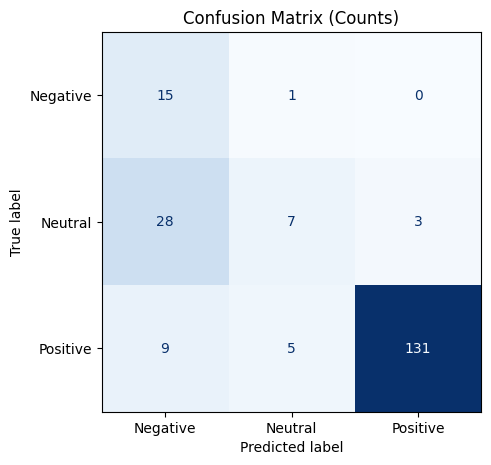

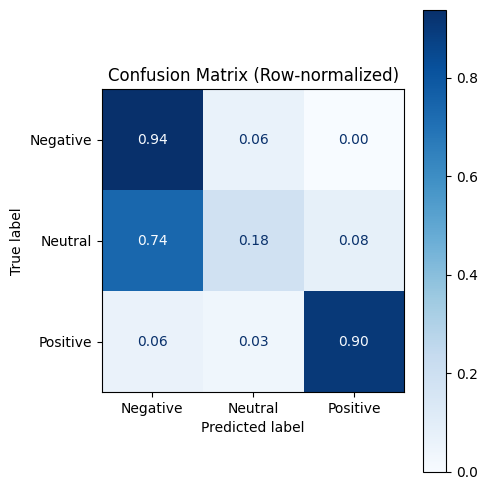

Support per class (truth): {'Negative': 16, 'Neutral': 39, 'Positive': 145}

Classification report (ordered labels):
              precision    recall  f1-score   support

    Negative       0.29      0.94      0.44        16
     Neutral       0.54      0.18      0.27        39
    Positive       0.98      0.90      0.94       145

   micro avg       0.77      0.77      0.77       200
   macro avg       0.60      0.67      0.55       200
weighted avg       0.84      0.77      0.77       200



In [31]:
# === CONFUSION MATRIX (Counts + Normalized) ===
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

labels = ["Negative","Neutral","Positive"]

# Pakai hanya baris yang punya weak label (ground truth)
mask = df_out["weak_sentiment"].notna()
y_true = df_out.loc[mask, "weak_sentiment"]
y_pred = df_out.loc[mask, "pred_sentiment"]

# 1) Confusion Matrix (counts)
cm = confusion_matrix(y_true, y_pred, labels=labels)
fig, ax = plt.subplots(figsize=(5,5))
ConfusionMatrixDisplay(cm, display_labels=labels).plot(ax=ax, values_format='d', cmap="Blues", colorbar=False)
ax.set_title("Confusion Matrix (Counts)")
plt.tight_layout()
plt.show()

# 2) Confusion Matrix (row-normalized) → proporsi per kelas sebenarnya
cm_norm = confusion_matrix(y_true, y_pred, labels=labels, normalize="true")
fig, ax = plt.subplots(figsize=(5,5))
ConfusionMatrixDisplay(cm_norm, display_labels=labels).plot(ax=ax, values_format=".2f", cmap="Blues", colorbar=True)
ax.set_title("Confusion Matrix (Row-normalized)")
plt.tight_layout()
plt.show()

# Tambahan info ringkas
print("Support per class (truth):", y_true.value_counts().reindex(labels, fill_value=0).to_dict())
print("\nClassification report (ordered labels):")
print(classification_report(y_true, y_pred, labels=labels))


##9. Label Distribution: Full vs Sample (Weak vs Pred)

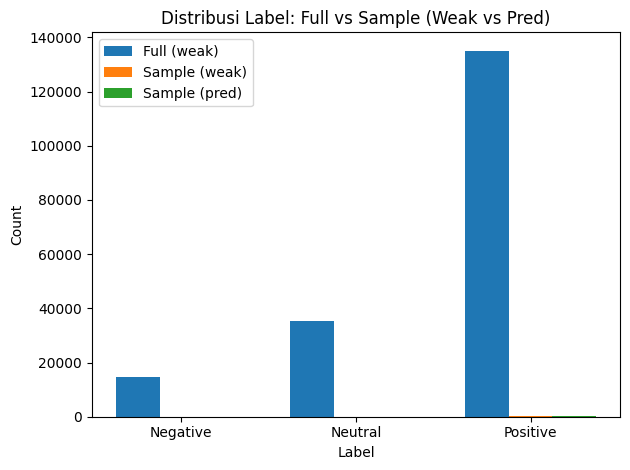

Full weak: {'Negative': np.int64(14608), 'Neutral': np.int64(35271), 'Positive': np.int64(135079)}
Sample weak: {'Negative': np.int64(16), 'Neutral': np.int64(39), 'Positive': np.int64(145)}
Sample pred: {'Negative': np.int64(52), 'Neutral': np.int64(13), 'Positive': np.int64(134)}


In [32]:
import numpy as np
import matplotlib.pyplot as plt

labels = ["Negative","Neutral","Positive"]

# Full (weak labels di seluruh df)
full_counts = df["weak_sentiment"].value_counts().reindex(labels, fill_value=0)

# Sample (weak vs pred di df_out)
sample_weak = df_out["weak_sentiment"].value_counts().reindex(labels, fill_value=0)
sample_pred = df_out["pred_sentiment"].value_counts().reindex(labels, fill_value=0)

# --- Bar side-by-side ---
x = np.arange(len(labels))
w = 0.25

fig, ax = plt.subplots()
ax.bar(x - w, full_counts.values, width=w, label="Full (weak)")
ax.bar(x,       sample_weak.values, width=w, label="Sample (weak)")
ax.bar(x + w, sample_pred.values, width=w, label="Sample (pred)")
ax.set_xticks(x); ax.set_xticklabels(labels)
ax.set_title("Distribusi Label: Full vs Sample (Weak vs Pred)")
ax.set_xlabel("Label"); ax.set_ylabel("Count"); ax.legend()
plt.tight_layout(); plt.show()

print("Full weak:", dict(zip(labels, full_counts.values)))
print("Sample weak:", dict(zip(labels, sample_weak.values)))
print("Sample pred:", dict(zip(labels, sample_pred.values)))


##10. Analysis Error

In [33]:
from collections import Counter
import pandas as pd

labels = ["Negative","Neutral","Positive"]
mask = df_out["weak_sentiment"].notna()
err = df_out.loc[mask & (df_out["weak_sentiment"] != df_out["pred_sentiment"])].copy()

print(f"Misclassifications: {len(err)} / {mask.sum()}")
pairs = list(zip(err["weak_sentiment"], err["pred_sentiment"]))
print("Top confusions:", Counter(pairs).most_common(5))

def show_examples(pair=("Neutral","Positive"), n=5):
    w, p = pair
    ex = err[(err["weak_sentiment"]==w) & (err["pred_sentiment"]==p)]
    cols = [text_col, "weak_sentiment", "pred_sentiment", "pred_summary"]
    print(f"\n=== Examples {w} → {p} (n={len(ex)}) ===")
    display(ex[cols].head(n))

# Tampilkan 3 pola salah paling sering (kalau ada)
for (w,p), _cnt in Counter(pairs).most_common(3):
    show_examples((w,p), n=5)


Misclassifications: 47 / 200
Top confusions: [(('Neutral', 'Negative'), 28), (('Positive', 'Negative'), 9), (('Positive', 'Neutral'), 5), (('Neutral', 'Positive'), 3), (('Negative', 'Neutral'), 1)]

=== Examples Neutral → Negative (n=28) ===


,review_text,weak_sentiment,pred_sentiment,pred_summary
11,Hikaru no Go was a long running manga written ...,Neutral,Negative,"Slow pacing, lack of stakes, and over-the-top ..."
15,Young Animator Training Project/Anime Mirai sh...,Neutral,Negative,"Lacking in interesting elements, weak characte..."
30,Monster is touted as a masterpiece of the psyc...,Neutral,Negative,"Despite praise for characters and story, the r..."
31,I am going to take a risky side with this revi...,Neutral,Negative,"Weaker characters, shallow significance, and d..."
32,"For quite the long time, people have exposed t...",Neutral,Negative,"Kyoukai no Kanata gagal di berbagai aspek, men..."



=== Examples Positive → Negative (n=9) ===


,review_text,weak_sentiment,pred_sentiment,pred_summary
2,I found the strong point in this series being ...,Positive,Negative,"Story intriguing at start, but harem aspect sl..."
46,If I were to describe this film in one word it...,Positive,Negative,Film Berserk: The Golden Age Arc I- The Egg of...
54,Zero Spoiler Review. [STORY = 8] This is one o...,Positive,Negative,"Mengingat kualitas cerita tahun pertama, pengg..."
69,Oh boy. I never thought my next review would b...,Positive,Negative,"Tournament arc disappoints, story lacks specta..."
86,Kaiji’s second season is not as good as Kaiji’...,Positive,Negative,Second season of Kaiji lacks the freshness and...



=== Examples Positive → Neutral (n=5) ===


,review_text,weak_sentiment,pred_sentiment,pred_summary
78,This is Hayao Miyazaki’s second major movie af...,Positive,Neutral,"Miyazaki's second major film, lighter than Nau..."
85,"Ok, i watched the movie just now and will make...",Positive,Neutral,"Brilliant animation, realistic battles, fluid ..."
89,"This anime is a ecchi, action, harem and schoo...",Positive,Neutral,"Cliched genres, unique setting with ancient we..."
124,You know what this series didn't need? More ch...,Positive,Neutral,"New characters add complexity, but some storyl..."
156,"Everything ahead is my own personal opinion, w...",Positive,Neutral,"Gosick mengandung cerita yang cukup, tetapi be..."


#12. Summary Analysis (Length & Language)

Summary length — median: 14 words | 95th: 24 words (target ≤ 25)
Proportion of English-ish summaries: 0.3

Examples of summaries >25 words (should be shorter):


,review_text,pred_summary,sum_len
46,If I were to describe this film in one word it...,Film Berserk: The Golden Age Arc I- The Egg of...,30
50,Kemono Friends didn't die....it was murde- it ...,"Kemono Friends 2 underwhelming, lacks original...",27
60,Not as much of a descent into despair as I exp...,"Less bleak than anticipated, last episodes wer...",36
120,As one of my all time favorites for the rest o...,"Favorit permanen, Kaitou Joker. Season 3 menaw...",32
149,"TL;DR: Great animation, shit story. Emphasize ...","Animation great, story poor; compares to recei...",29


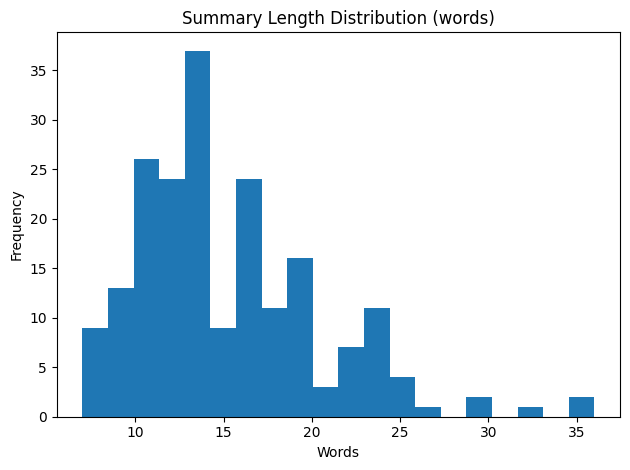

In [34]:
import re
import numpy as np
import matplotlib.pyplot as plt

def count_words(s):
    return len(str(s).split())

df_out["sum_len"] = df_out["pred_summary"].map(count_words)

# Stats length
med = df_out["sum_len"].median()
p95 = df_out["sum_len"].quantile(0.95)
print(f"Summary length — median: {med:.0f} words | 95th: {p95:.0f} words (target ≤ 25)")

# Simple English-ness check (lightweight, no external libs)
EN_STOP = set("""
the a an is are was were be been being i you he she it we they this that these those
of to in for on with as by from at about into over after before between out up down off
above under again further then once here there when where why how all any both each few
more most other some such no nor not only own same so than too very can will just
""".split())

def is_englishish(text: str):
    text = str(text)
    words = re.findall(r"[A-Za-z']+", text.lower())
    if not words:
        return False
    stop_hits = sum(w in EN_STOP for w in words)
    alpha_ratio = sum(c.isalpha() for c in text) / max(1, len(text))
    return (stop_hits >= 3) and (alpha_ratio > 0.7)

df_out["is_englishish"] = df_out["pred_summary"].apply(is_englishish)
print("Proportion of English-ish summaries:", round(df_out["is_englishish"].mean(), 3))

# Examples too long (>25 words)
longs = df_out[df_out["sum_len"] > 25][[text_col, "pred_summary", "sum_len"]].head(5)
if len(longs):
    print("\nExamples of summaries >25 words (should be shorter):")
    display(longs)

# Histogram of summary length
plt.figure()
plt.hist(df_out["sum_len"], bins=20)
plt.title("Summary Length Distribution (words)")
plt.xlabel("Words"); plt.ylabel("Frequency")
plt.tight_layout(); plt.show()
